Current error: 1.3638079012812616
Current number of layers: 0
Current error: 1.2018443189450112
Current number of layers: 0


/workspaces/QCproject/.venv/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


m=10: Fidelity=1.000000, Error=0.000000
m=20: Fidelity=1.000000, Error=0.000000
m=30: Fidelity=1.000000, Error=0.000000
m=40: Fidelity=1.000000, Error=0.000000
m=50: Fidelity=1.000000, Error=0.000000
m=60: Fidelity=1.000000, Error=0.000000
m=70: Fidelity=1.000000, Error=0.000000
m=80: Fidelity=1.000000, Error=0.000000
m=90: Fidelity=1.000000, Error=0.000000
m=100: Fidelity=1.000000, Error=0.000000


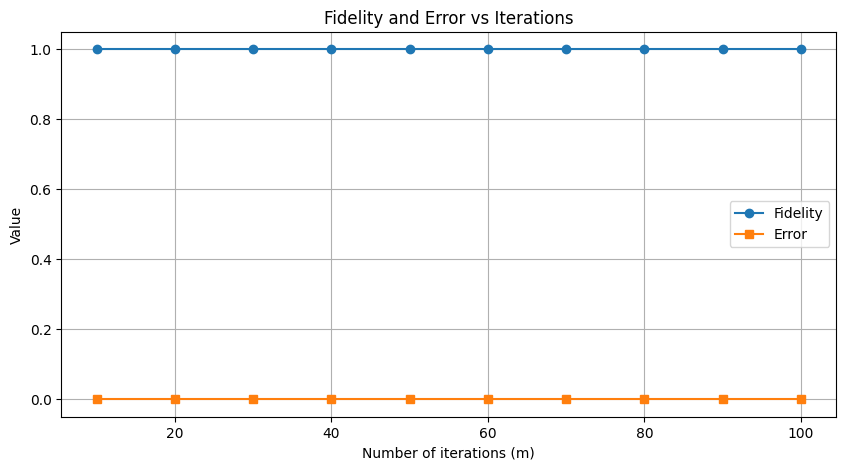

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


psi = [1, 2, 3, 4, 5, 6, 7, 8]
N = 8
x = np.linspace(0, 1, N, endpoint=False)   # 8 grid points
k = 3  # quantum number (1 = ground state)
phi = np.sqrt(2) * np.sin(k * np.pi * (x + 0.5/N))

n = 3  
delta = np.pi / 4000    # small phase
number_of_layers = 2

psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()




def run_protocol(m):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    creg = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    # iterative protocol
    for k in range(1, m+1):
        # CNOT flags
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # apply small phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute φ, measure, reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        if k < m:
            qc.append(U_phi, phi_reg)

    # simulate
    sim = AerSimulator()
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # reduced density matrix for ψ
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    #Ideal target
    psi_vec = np.array(psi) / np.linalg.norm(psi)   # normalized ψ
    phi_vec = np.array(phi) / np.linalg.norm(phi)   # normalized φ
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    # fidelity
    fid = state_fidelity(rho_psi, rho_ideal)
    err = 1 - fid
    return fid, err, full_state


# --- run for different m ---
m_values = list(range(10, 101, 10))
fidelities, errors = [], []

for m in m_values:
    fid, err, _ = run_protocol(m)
    fidelities.append(fid)
    errors.append(err)
    print(f"m={m}: Fidelity={fid:.6f}, Error={err:.6f}")

# --- plot results ---
plt.figure(figsize=(10,5))
plt.plot(m_values, fidelities, 'o-', label="Fidelity")
plt.plot(m_values, errors, 's-', label="Error")
plt.xlabel("Number of iterations (m)")
plt.ylabel("Value")
plt.title("Fidelity and Error vs Iterations")
plt.legend()
plt.grid(True)
plt.show()


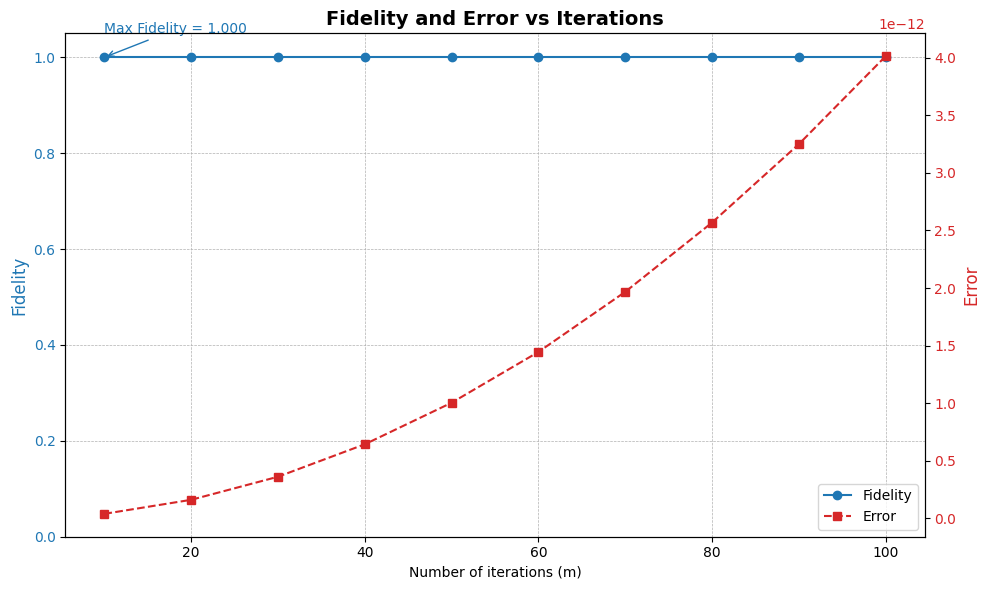

In [2]:
# --- enhanced visualization ---
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:blue'
ax1.set_xlabel("Number of iterations (m)")
ax1.set_ylabel("Fidelity", color=color1, fontsize=12)
ax1.plot(m_values, fidelities, 'o-', color=color1, label="Fidelity")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, 1.05)

# Annotate the max fidelity point
max_fid_idx = np.argmax(fidelities)
ax1.annotate(f"Max Fidelity = {fidelities[max_fid_idx]:.3f}",
             xy=(m_values[max_fid_idx], fidelities[max_fid_idx]),
             xytext=(m_values[max_fid_idx], fidelities[max_fid_idx]+0.05),
             arrowprops=dict(arrowstyle="->", color=color1),
             color=color1)

# Create second y-axis for error
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Error", color=color2, fontsize=12)
ax2.plot(m_values, errors, 's--', color=color2, label="Error")
ax2.tick_params(axis='y', labelcolor=color2)

# Optionally, log scale for error (uncomment if errors are very small)
# ax2.set_yscale('log')

# Title and grid
plt.title("Fidelity and Error vs Iterations", fontsize=14, fontweight='bold')
fig.tight_layout()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

plt.show()


Example m=100: Fidelity=1.000000, Error=0.000000


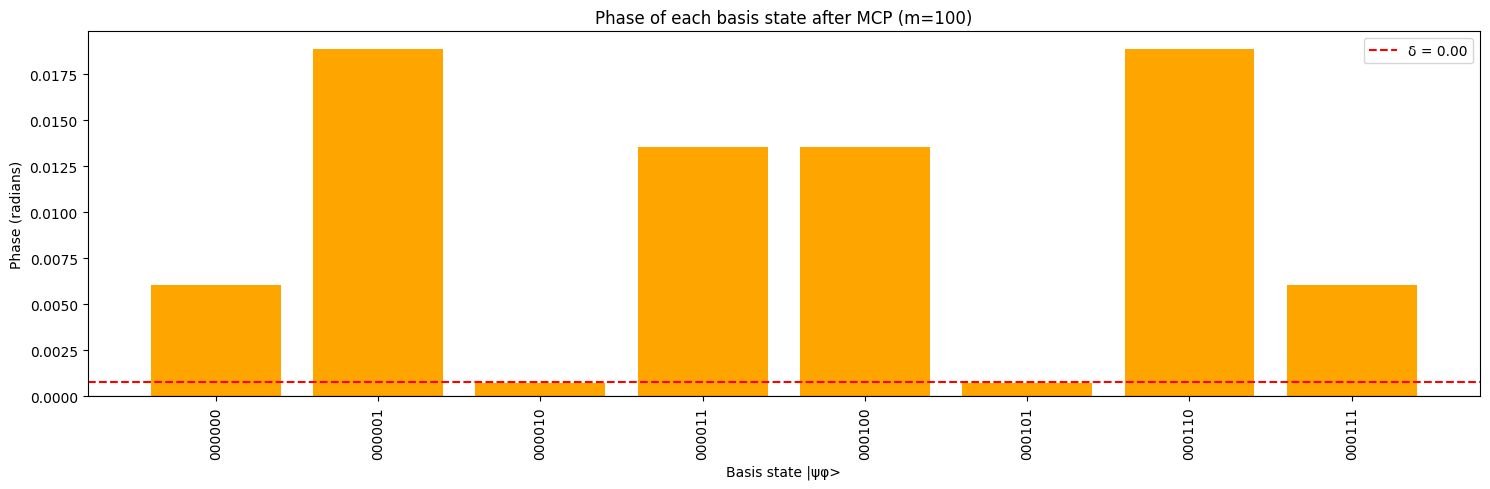

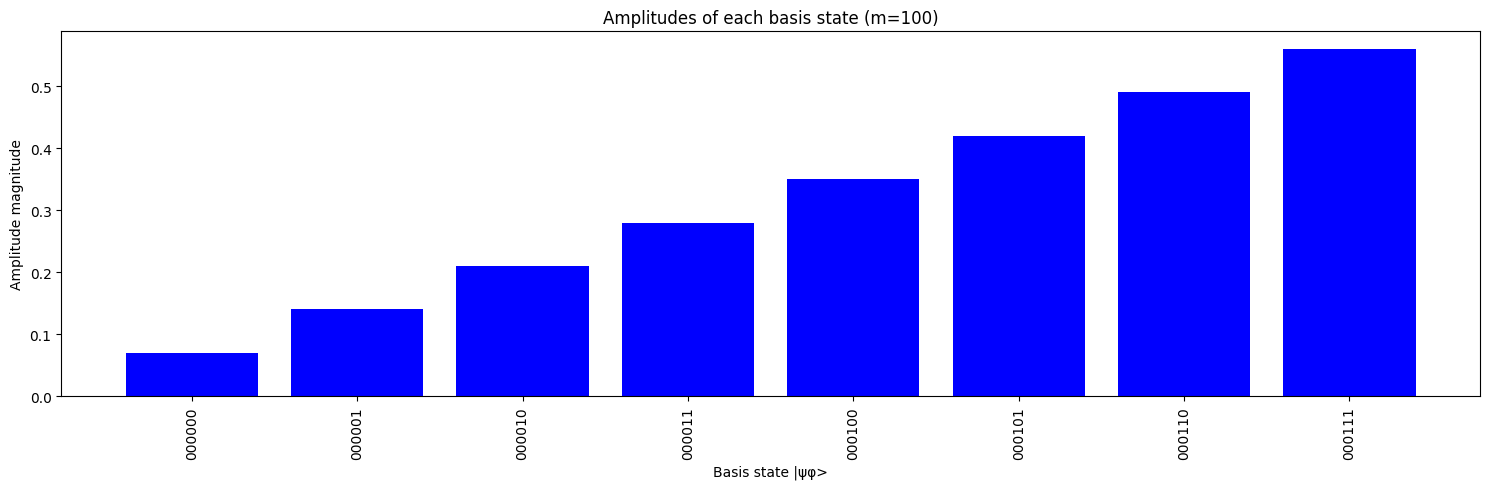

In [4]:
# Pick one m to analyze (example: m=20)
m_example = 100
fid_ex, err_ex, full_state = run_protocol(m_example)

print(f"Example m={m_example}: Fidelity={fid_ex:.6f}, Error={err_ex:.6f}")

# Get amplitudes and phases
amps = np.abs(full_state)
phases = np.angle(full_state)

# Create basis labels
basis_labels = [format(i, f'0{n*2}b') for i in range(len(amps))]

# --- Plot phases ---
plt.figure(figsize=(15,5))
plt.bar(basis_labels[0:8], phases[0:8], color='orange')   # show first 16 states
plt.axhline(delta, color='red', linestyle='--', label=f"δ = {delta:.2f}")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Phase (radians)")
plt.xlabel("Basis state |ψφ>")
plt.xticks(rotation=90)
plt.title(f"Phase of each basis state after MCP (m={m_example})")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot amplitudes ---
plt.figure(figsize=(15,5))
plt.bar(basis_labels[0:8], amps[0:8], color='blue')
plt.ylabel("Amplitude magnitude")
plt.xlabel("Basis state |ψφ>")
plt.title(f"Amplitudes of each basis state (m={m_example})")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
